In [10]:
import numpy as np
import numpy.linalg as npl

def modNewtonBcktrck(x0, f, gradf, hessf, alpha0, kmax, tolgrad, c1, rho, btmax):
    xk = x0.copy()
    k = 0
    
    # Store the sequence of iterates
    xseq = [xk.copy()]
    grad_xk = gradf(xk)
    gradfk_norm = npl.norm(grad_xk)
    n = len(x0) # Dimensione del problema
    while k < kmax and gradfk_norm > tolgrad:
        H = hessf(xk)
        # --- INIZIO MODIFICA PER NEWTON MODIFICATO ---
        # Cerchiamo di rendere H definita positiva aggiungendo tau * I
        tau = 0
        beta = 1e-3  # Valore iniziale piccolo se tau deve essere aumentato
        while True:
            # Creiamo la matrice modificata: B = H + tau * I
            B = H + tau * np.eye(n)
            
            try:
                # Proviamo la fattorizzazione di Cholesky.
                # Se funziona, B è definita positiva.
                # Se lancia LinAlgError, B non è definita positiva.
                np.linalg.cholesky(B)
                
                # Se siamo qui, la matrice è OK. Risolviamo il sistema.
                # B * pk = -grad
                pk = -np.linalg.solve(B, grad_xk)
                break # Usciamo dal loop di correzione tau
                
            except np.linalg.LinAlgError:
                # La matrice non è definita positiva. Aumentiamo tau.
                if tau == 0:
                    tau = beta
                else:
                    tau = 2 * tau # Aumentiamo rapidamente tau
        # --- FINE MODIFICA ---

        # Backtracking Line Search
        alpha_k = getAlpha(f, gradf, xk, pk, alpha0, rho, c1, btmax)
        
        # Aggiornamento xk
        xk = xk + alpha_k * pk
        
        # Calcolo gradienti per la prossima iterazione
        grad_xk = gradf(xk)
        gradfk_norm = npl.norm(grad_xk)
        
        k += 1
        xseq.append(xk.copy())
        
    xseq = np.column_stack(xseq)
    return xk, f(xk), gradfk_norm, k, xseq

def getAlpha(f, grad_f, x, p, alpha0=1.0, rho=0.5, c=1e-4, btmax=20):
    k = 0
    satisfyed = False
    fx = f(x)
    grad_fx = grad_f(x)
    
    # Pre-calcoliamo il termine lineare per efficienza
    grad_dot_p = np.dot(grad_fx, p)
    
    while k < btmax and not satisfyed:
        alpha = alpha0 * (rho ** k)
        # Condizione di Armijo
        if f(x + alpha * p) <= fx + c * alpha * grad_dot_p:
            satisfyed = True
            print(k)
        else:
            k += 1
    
    return alpha if satisfyed else alpha0 * (rho ** btmax)

In [11]:
def broyden_tridiagonal(x):
    """
    Calcola la funzione obiettivo tridiagonale di Broyden.
    
    F(x) = 0.5 * sum(f_k(x)^2)
    
    Dove:
    f_k(x) = (3 - 2*x_k)*x_k - x_{k-1} - 2*x_{k+1} + 1
    con x_0 = x_{n+1} = 0
    """
    x = np.asarray(x)
    n = len(x)
    
    # Creiamo un array con padding di zeri all'inizio e alla fine
    # per gestire x_0 e x_{n+1} automaticamente.
    # x_pad diventerà: [0, x_1, x_2, ..., x_n, 0]
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    
    # Definiamo i vettori spostati per il calcolo vettorizzato
    # x_k corrisponde agli elementi centrali (l'input originale)
    x_k = x_pad[1:-1]      
    # x_{k-1} corrisponde agli elementi spostati a sinistra
    x_prev = x_pad[0:-2]   
    # x_{k+1} corrisponde agli elementi spostati a destra
    x_next = x_pad[2:]     
    
    # Calcolo del vettore f_k per tutti i k da 1 a n simultaneamente
    # Formula: (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    f_vec = (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1
    
    # Calcolo finale di F(x)
    F_x = 0.5 * np.sum(f_vec**2)
    
    return F_x

# --- ESEMPIO DI UTILIZZO ---

# Dimensione del problema (n)
n = 10

# Punto iniziale come indicato nell'immagine: x_l = -1
x0 = -1 * np.ones(n)

risultato = broyden_tridiagonal(x0)

print(f"Dimensione n: {n}")
print(f"Punto iniziale x: {x0}")
print(f"Risultato F(x): {risultato}")

Dimensione n: 10
Punto iniziale x: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Risultato F(x): 10.5


0
0
0
0
0
0

Risultato Finale:
Iterazioni totali: 6
Punto di minimo trovato (primi 5 elementi): [-0.57076119 -0.68191013 -0.70248602 -0.70626058 -0.70695185]...
Valore funzione al minimo: 5.842501079293119e-30
Norma gradiente finale: 2.16282422871868e-14


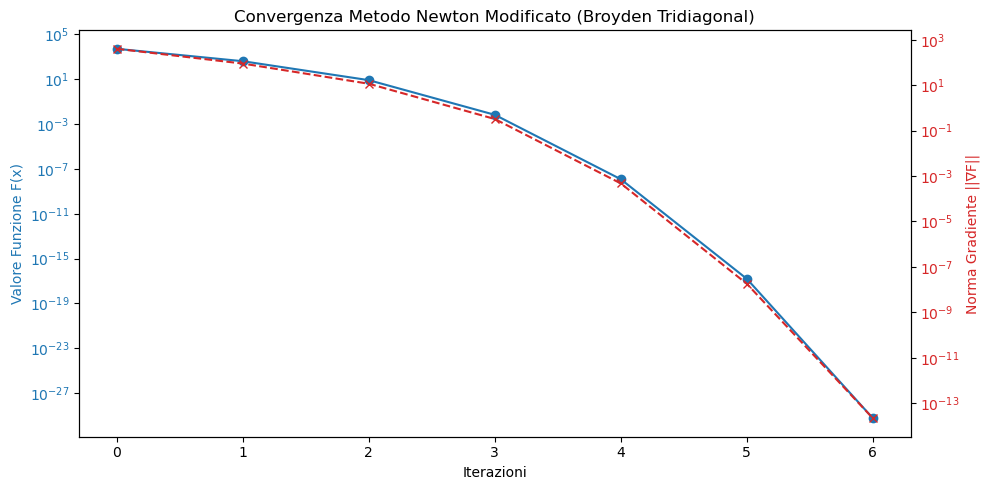

In [12]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. DEFINIZIONE DEL PROBLEMA (Funzione, Gradiente, Hessiana)
# ---------------------------------------------------------

def get_f_vec(x):
    """Calcola il vettore dei residui f_k(x)"""
    x = np.asarray(x)
    # Padding: x_0=0, x_{n+1}=0
    x_pad = np.pad(x, (1, 1), mode='constant', constant_values=0)
    x_k = x_pad[1:-1]
    x_prev = x_pad[0:-2]
    x_next = x_pad[2:]
    # f_k = (3 - 2x_k)x_k - x_{k-1} - 2x_{k+1} + 1
    return (3 - 2 * x_k) * x_k - x_prev - 2 * x_next + 1

def get_jacobian(x):
    """Calcola la matrice Jacobiana J di f(x). J è tridiagonale."""
    n = len(x)
    J = np.zeros((n, n))
    
    # Diagonale principale: derivata parziale di f_k rispetto a x_k
    # d(f_k)/d(x_k) = 3 - 4*x_k
    diag_val = 3 - 4 * x
    np.fill_diagonal(J, diag_val)
    
    # Diagonale inferiore: derivata parziale di f_k rispetto a x_{k-1}
    # d(f_k)/d(x_{k-1}) = -1
    idx_lower = np.arange(1, n)
    J[idx_lower, idx_lower - 1] = -1
    
    # Diagonale superiore: derivata parziale di f_k rispetto a x_{k+1}
    # d(f_k)/d(x_{k+1}) = -2
    idx_upper = np.arange(0, n - 1)
    J[idx_upper, idx_upper + 1] = -2
    
    return J

def broyden_func(x):
    """Funzione Obiettivo Scalare F(x)"""
    f_vec = get_f_vec(x)
    return 0.5 * np.sum(f_vec**2)

def broyden_grad(x):
    """Gradiente di F(x) = J^T * f"""
    f_vec = get_f_vec(x)
    J = get_jacobian(x)
    return J.T @ f_vec

def broyden_hess(x):
    """
    Hessiana di F(x).
    H = J^T * J + sum(f_k * Hessian(f_k))
    
    Nota: Hessian(f_k) è molto sparsa. La derivata seconda di f_k 
    rispetto a x_k è -4. Le miste sono 0.
    Quindi il secondo termine è una matrice diagonale.
    """
    f_vec = get_f_vec(x)
    J = get_jacobian(x)
    
    # Termine Gauss-Newton
    H_gn = J.T @ J
    
    # Termine del secondo ordine (S = sum f_k * nabla^2 f_k)
    # nabla^2 f_k ha solo l'elemento (k,k) = -4 diverso da zero
    S = np.diag(-4 * f_vec)
    
    return H_gn + S

# ---------------------------------------------------------
# 3. ESECUZIONE DEL TEST
# ---------------------------------------------------------

# Parametri del problema
n = 10000  # Dimensione
x0 = -1 * np.ones(n) # Punto iniziale standard (-1, -1, ...)

# Esecuzione
xk_final, f_final, grad_norm, iterations, xseq = modNewtonBcktrck(
    x0, 
    broyden_func, 
    broyden_grad, 
    broyden_hess,
    alpha0=1.0, 
    kmax=100, 
    tolgrad=1e-8, 
    c1=1e-4, 
    rho=0.5, 
    btmax=50
)

print(f"\nRisultato Finale:")
print(f"Iterazioni totali: {iterations}")
print(f"Punto di minimo trovato (primi 5 elementi): {xk_final[:5]}...")
print(f"Valore funzione al minimo: {f_final}")
print(f"Norma gradiente finale: {grad_norm}")

# ---------------------------------------------------------
# 4. GRAFICO CONVERGENZA
# ---------------------------------------------------------
history_f = [broyden_func(xseq[:, i]) for i in range(xseq.shape[1])]
history_g = [npl.norm(broyden_grad(xseq[:, i])) for i in range(xseq.shape[1])]

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterazioni')
ax1.set_ylabel('Valore Funzione F(x)', color=color)
ax1.plot(history_f, color=color, marker='o', label='F(x)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Norma Gradiente ||∇F||', color=color) 
ax2.plot(history_g, color=color, linestyle='--', marker='x', label='||Grad||')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title('Convergenza Metodo Newton Modificato (Broyden Tridiagonal)')
fig.tight_layout()
plt.show()